##### 张培源

In [10]:
!pip install -i https://mirrors.aliyun.com/pypi/simple/ matplotlib

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


### 1.导入相应的包
准备好进行深度学习项目所需的库和工具，包括神经网络构建、数据处理、可视化以及实验记录等。

In [32]:
#导入需要的包
import torch
from torch import nn
from torch.nn import *
import torchvision
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

### 2.获得数据
CIFAR10对应的下载链接:http://www.cs.toronto.edu/~kriz/cifar.html
#### 2.1加载数据
使用Pytorch的datasets模块直接从下载地址中将训练集和测试集的数据导入本地文件,并进行相应处理
torchvision.transforms.Compose是一个类，用于组合多个图像变换操作。
这里使用了以下变换：
torchvision.transforms.ToTensor()：将图片转换为PyTorch张量，并将像素值范围从[0, 255]缩放到[0, 1]。
torchvision.transforms.RandomCrop(32, 4)：随机裁剪图片，保持图片的宽高为32x32。4表示四周填充0的宽度。
torchvision.transforms.RandomHorizontalFlip(0.5)：随机水平翻转图片，翻转的概率为0.5。
这些变换是为了增加数据的多样性和防止过拟合。

#### CIFAR10数据一览
![这是datasets的图片](https://pic3.zhimg.com/80/v2-fc78aadab1b907fb80906b9aa5bdd7f2_720w.webp)

In [33]:
# 准备数据集
train_data = torchvision.datasets.CIFAR10('./dataset', True, torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # 对训练集做处理避免过拟合
    torchvision.transforms.RandomCrop(32,4), # 先四周填充0，再把图像随机裁剪成32*32
    torchvision.transforms.RandomHorizontalFlip(0.5), # 随机水平翻转 选择一个概率概率
]))
#改进前的算法
train_data_1 = torchvision.datasets.CIFAR10('./dataset', True, torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_data = torchvision.datasets.CIFAR10('./dataset', False, torchvision.transforms.ToTensor())

#### 2.2 获得训练集和测试集的大小

In [34]:
# length长度
train_data_size = len(train_data)
test_data_size = len(test_data)

print(f'train_data的长度是:{train_data_size}')
print(f'test_data的长度是:{test_data_size}')

train_data的长度是:50000
test_data的长度是:10000


#### 2.3利用dataloader加载数据集,其中包含两个模型的数据集,分别是优化前的模型和优化后的模型

In [35]:
# 利用dataloader加载数据集
train_dataloader = DataLoader(train_data, 64)

train_dataloader_1 = DataLoader(train_data_1, 64)

test_dataloader = DataLoader(test_data, 64)

#### 2.4数据展示

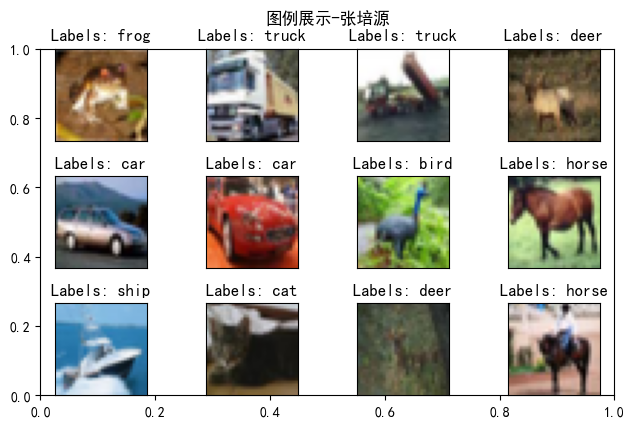

In [36]:
fig = plt.figure()
classes=['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
plt.title('图例展示-张培源',x = 0.5, y = 1.05)
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    (_, label) = train_data[i] 
    plt.imshow(train_dataloader.dataset.data[i],cmap=plt.cm.binary)
    plt.title("Labels: {}".format(classes[label]))
    plt.xticks([])
    plt.yticks([])
plt.show()

### 3搭建神经网络
#### 3.1经过优化后的网络模型
创建了一个Sequential模型，这是一个顺序容器，用于将多个层线性堆叠。Sequential模型中的层按照它们在列表中出现的顺序执行。列表中的层包括：
Conv2d(3, 32, 5, padding=2)：一个卷积层，输入通道数为3，输出通道数为32，卷积核大小为5，填充大小为2。

MaxPool2d(2)：一个最大池化层，池化窗口大小为2x2。

ReLU(True)：一个ReLU激活函数，激活函数应用于其前的层输出。

Conv2d(32, 32, 5, padding=2)：另一个卷积层，输入通道数为32，输出通道数也为32。

MaxPool2d(2)：另一个最大池化层。

ReLU(True)：另一个ReLU激活函数。

Conv2d(32, 64, 5, padding=2)：第三个卷积层，输入通道数为32，输出通道数为64。

MaxPool2d(2)：第三个最大池化层。

ReLU(True)：第三个ReLU激活函数。

Flatten()：一个展平层，将输入展平为一维张量，这是为了准备输入到线性层。

Linear(1024, 64)：一个全连接层（线性层），输入特征数为1024，输出特征数为64。

Linear(64, 10)：另一个全连接层，输入特征数为64，输出特征数为10

In [37]:
# 搭建神经网路(优化)
class CF_module(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model1 = Sequential(
            Conv2d(3, 32, 5, padding=2),
            MaxPool2d(2),
            ReLU(True),
            
            Conv2d(32, 32, 5, padding=2),
            MaxPool2d(2),
            ReLU(True),
            
            Conv2d(32, 64, 5, padding=2),
            MaxPool2d(2),
            ReLU(True),
            
            Flatten(),  # 将数据展成一维的(为线性层做准备)
            Linear(1024, 64),
            Linear(64, 10)
        )
    def forward(self, input):
        return self.model1(input)

#### 3.2优化前的网络模型
创建了一个Sequential模型，这是一个顺序容器，用于将多个层线性堆叠。Sequential模型中的层按照它们在列表中出现的顺序执行。列表中的层包括：
Conv2d(3, 32, 5, padding=2)：一个卷积层，输入通道数为3，输出通道数为32，卷积核大小为5，填充大小为2。

MaxPool2d(2)：一个最大池化层，池化窗口大小为2x2。

Conv2d(32, 32, 5, padding=2)：另一个卷积层，输入通道数为32，输出通道数也为32。

MaxPool2d(2)：另一个最大池化层。

Conv2d(32, 64, 5, padding=2)：第三个卷积层，输入通道数为32，输出通道数为64。

MaxPool2d(2)：第三个最大池化层。

Flatten()：一个展平层，将输入展平为一维张量，这是为了准备输入到线性层。

Linear(1024, 64)：一个全连接层（线性层），输入特征数为1024，输出特征数为64。

Linear(64, 10)：另一个全连接层，输入特征数为64，输出特征数为10。

In [38]:
# 搭建神经网路(优化前)
class CF_module_1(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model1 = Sequential(
            Conv2d(3, 32, 5, padding=2),
            MaxPool2d(2),
            
            Conv2d(32, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 64, 5, padding=2),
            MaxPool2d(2),
            
            Flatten(),  # 将数据展成一维的(为线性层做准备)
            Linear(1024, 64),
            Linear(64, 10)
        )
    def forward(self, input):
        return self.model1(input)

#### 3.3实例化网络模型,并为两个模型启用GPU加速

In [39]:
# 实例化网络模型
cf = CF_module()
cf_1 = CF_module_1()
# 采用GPU加速
cf = cf.cuda()
cf_1 = cf_1.cuda()

### 4训练模型的重要参数

#### 4.1交叉熵损失函数

In [40]:
# 损失函数(交叉熵函数,一般用于分类)
loss_cross = CrossEntropyLoss()
loss_cross = loss_cross.cuda()

#### 4.2参数优化器

In [41]:
# 优化器
learning_rate = 0.001
optim = torch.optim.Adam(cf.parameters(), lr = learning_rate)

optim_1 = torch.optim.Adam(cf_1.parameters(), lr = learning_rate)

#### 4.3训练训练和测试次数

In [42]:
# 设置训练网络的一些参数
# 记录训练的次数
total_train_step = 0
total_train_step_1 = 0

# 记录测试的次数
total_test_step = 0
# 训练的轮数
epoch = 50

### 5.开始训练模型

#### 5.1初始化数组：
代码开始时创建了四个空数组，分别为train_loss_、train_loss_1、test_loss_和test_loss_1
用于存储训练损失和测试损失。另外还创建了两个空数组accuracy_和accuracy_2，用于存储训练和测试的准确率。

#### 5.2训练循环(优化后)：
代码包含一个循环，用于训练优化后的模型。在每次迭代中，代码执行以下步骤：

将输入图像和标签加载到GPU上；
前向传播计算输出；
计算损失值；
清除梯度；
反向传播；
更新模型参数。
在每400个训练步骤后，代码将当前的损失值追加到train_loss_数组中。

#### 5.3训练循环（优化前）：
与训练循环类似，但用于训练优化前的模型。每400个训练步骤后，代码将损失值追加到train_loss_1数组中。

#### 5.4测试循环：
在测试阶段，代码计算测试集上的准确率和损失。代码执行以下步骤：

将输入图像和标签加载到GPU上；
前向传播计算输出；
计算损失值；
计算准确率；
更新损失和准确率数组。
在每次测试步骤后，代码将测试损失和准确率追加到相应的数组中。

In [43]:
#创建train_loss数组
train_loss_ = np.array([])
#创建train_loss数组(优化前)
train_loss_1 = np.array([])

#创建test_loss数组
test_loss_ = np.array([])
#创建test_loss数组(优化前)
test_loss_1 = np.array([])
#


#创建accuracy数组
accuracy_ = np.array([])
#创建accuracy数组(优化前)
accuracy_2 = np.array([])

for i in range(epoch):
    print(f'第{i}轮训练开始了')
    #训练优化后的模型
    for data in train_dataloader:
        total_train_step += 1
        imgs, labels = data
        
        imgs = imgs.cuda()
        labels = labels.cuda()

        output = cf(imgs)
        # 计算损失值
        res = loss_cross(output, labels)
        # 梯度清零
        optim.zero_grad()
        # 反向传播
        res.backward()
        # 优化器
        optim.step()
        if total_train_step % 400 == 0:
            train_loss_ = np.append(train_loss_, res.item())
    
    #训练优化前的模型
    for data in train_dataloader_1:
        total_train_step_1 += 1
        imgs, labels = data
        
        imgs = imgs.cuda()
        labels = labels.cuda()
        
        #获得输出值
        output = cf_1(imgs)
        # 计算损失值
        res = loss_cross(output, labels)
        # 梯度清零
        optim_1.zero_grad()
        # 反向传播
        res.backward()
        # 优化器
        optim_1.step()
        if total_train_step_1 % 400 == 0:
            train_loss_1 = np.append(train_loss_1, res.item())
            
    # 测试步骤开始
    # 建立正确率
    total_accuracy = 0
    total_accuracy_1 = 0
    
    total_test_loss = 0
    total_test_loss_1 = 0
    
    # 因为只需要测试,不需要优化,所以要把梯度都设置为0
    with torch.no_grad():
        for data in test_dataloader:
            imgs, labels = data
            imgs = imgs.cuda()
            labels = labels.cuda()

            output = cf(imgs)
            output_1 = cf_1(imgs)
            
            res = loss_cross(output, labels)
            res_1 = loss_cross(output_1, labels)
            
            total_test_loss += res
            total_test_loss_1 += res_1
            
            # 计算正确次数
            # 一次计算64张图片的预测结果,所以使用求和符号
            accuracy = (output.argmax(1) == labels).sum()
            accuracy_1 = (output_1.argmax(1) == labels).sum()
            
            total_accuracy += accuracy
            total_accuracy_1 += accuracy_1
            
   
    test_loss_ = np.append(test_loss_, total_test_loss.item())
    test_loss_1 = np.append(test_loss_1, total_test_loss_1.item())
    

    accuracy_ = np.append(accuracy_, total_accuracy.item()/test_data_size)
    accuracy_2 = np.append(accuracy_2, total_accuracy_1.item()/test_data_size)
    
    total_test_step += 1
    
    #每训练一轮保存一次数据
    torch.save(cf, f'cf_{i}.pth')
    print('模型已保存')
    

第0轮训练开始了
模型已保存
第1轮训练开始了
模型已保存
第2轮训练开始了
模型已保存
第3轮训练开始了
模型已保存
第4轮训练开始了
模型已保存
第5轮训练开始了
模型已保存
第6轮训练开始了
模型已保存
第7轮训练开始了
模型已保存
第8轮训练开始了
模型已保存
第9轮训练开始了
模型已保存
第10轮训练开始了
模型已保存
第11轮训练开始了
模型已保存
第12轮训练开始了
模型已保存
第13轮训练开始了
模型已保存
第14轮训练开始了
模型已保存
第15轮训练开始了
模型已保存
第16轮训练开始了
模型已保存
第17轮训练开始了
模型已保存
第18轮训练开始了
模型已保存
第19轮训练开始了
模型已保存
第20轮训练开始了
模型已保存
第21轮训练开始了
模型已保存
第22轮训练开始了
模型已保存
第23轮训练开始了
模型已保存
第24轮训练开始了
模型已保存
第25轮训练开始了
模型已保存
第26轮训练开始了
模型已保存
第27轮训练开始了
模型已保存
第28轮训练开始了
模型已保存
第29轮训练开始了
模型已保存
第30轮训练开始了
模型已保存
第31轮训练开始了
模型已保存
第32轮训练开始了
模型已保存
第33轮训练开始了
模型已保存
第34轮训练开始了
模型已保存
第35轮训练开始了
模型已保存
第36轮训练开始了
模型已保存
第37轮训练开始了
模型已保存
第38轮训练开始了
模型已保存
第39轮训练开始了
模型已保存
第40轮训练开始了
模型已保存
第41轮训练开始了
模型已保存
第42轮训练开始了
模型已保存
第43轮训练开始了
模型已保存
第44轮训练开始了
模型已保存
第45轮训练开始了
模型已保存
第46轮训练开始了
模型已保存
第47轮训练开始了
模型已保存
第48轮训练开始了
模型已保存
第49轮训练开始了
模型已保存


### 6绘制可视化模型
#### 6.1创建x轴
创建三个数组x_train_loss、x_test_loss和x_accuracy，
这些数组将作为绘图的横坐标数据。这三个数组分别对应于训练损失、测试损失和训练准确率的数据点索引。

In [44]:
#为plt创建x
x_train_loss = np.arange(0,len(train_loss_)*400, 400)
x_test_loss = np.arange(0,len(test_loss_))
x_accuracy = np.arange(0,len(accuracy_))

#### 6.2 绘制训练损失随训练轮数变化的曲线图
展示了优化前后的训练损失随训练轮数的变化情况

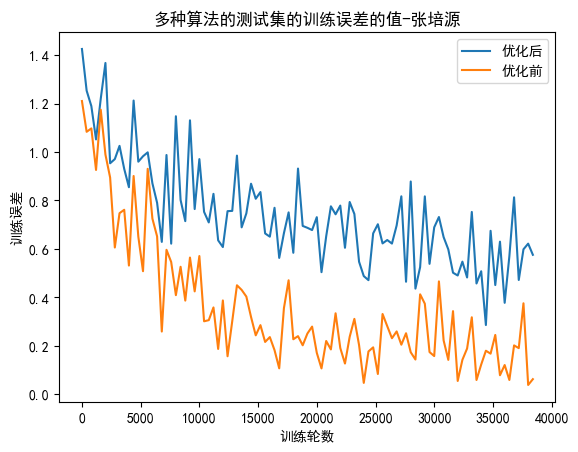

In [45]:
fig, ax = plt.subplots() # 创建图实例
x = x_train_loss
y1 = train_loss_
ax.plot(x, y1, label='优化后') # 作图，并标记此线名为优化后
y2 = train_loss_1
ax.plot(x, y2, label='优化前') #作图，并标记此线名为优化前
plt.title('多种算法的测试集的训练误差的值-张培源')
ax.set_xlabel('训练轮数') #设置x轴名称
ax.set_ylabel('训练误差') #设置y轴名称
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show()

#### 6.3绘制测试损失随训练轮数变化的曲线图
展示了优化前后的测试损失随训练轮数的变化情况

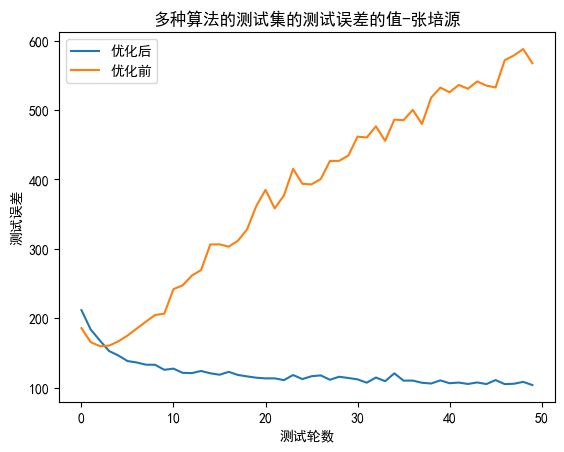

In [46]:
fig, ax = plt.subplots() # 创建图实例
x = x_test_loss
y1 = test_loss_
ax.plot(x, y1, label='优化后') # 作图，并标记此线名为优化后
y2 = test_loss_1
ax.plot(x, y2, label='优化前') #作图，并标记此线名为优化前
ax.set_xlabel('测试轮数') #设置x轴名称
ax.set_ylabel('测试误差') #设置y轴名称
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.title('多种算法的测试集的测试误差的值-张培源')
plt.show()

#### 6.4 绘制精确度随训练轮数变化的曲线图
展示了优化前后的精确度随训练轮数的变化情况

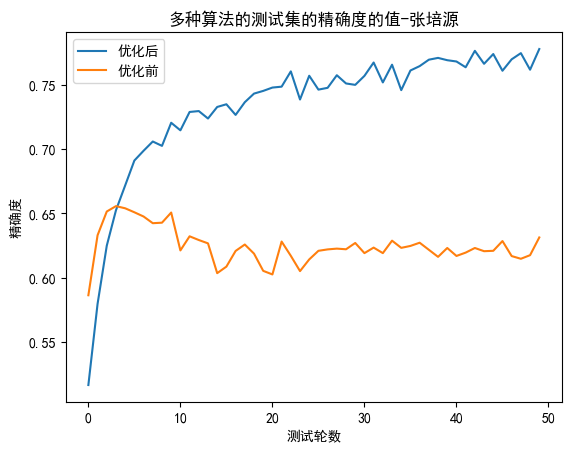

In [47]:
fig, ax = plt.subplots() # 创建图实例
x = x_accuracy
y1 = accuracy_
ax.plot(x, y1, label='优化后') # 作y1 = x 图，并标记此线名为优化后
y2 = accuracy_2
ax.plot(x, y2, label='优化前') #作y2 = x^2 图，并标记此线名为优化前
ax.set_xlabel('测试轮数') #设置x轴名称
ax.set_ylabel('精确度') #设置y轴名称
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.title('多种算法的测试集的精确度的值-张培源')
plt.show()

### 7模型测试
#### 7.1选取经过50轮训练后得到的最优模型

In [48]:
model = torch.load(r"cf_43.pth")

#### 7.2从网络中选取图片进行测试
##### 7.2.1airplane

In [49]:
image_path = r"./aircraft.png"
# 读取图片（PIL Image），再用ToTensor进行转换
image = Image.open(image_path)  # 现在的image是PIL类型
image = image.convert('RGB')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32)),  # 32x32大小的PIL Image
                                            torchvision.transforms.ToTensor()])  # 转为Tensor数据类型
image = transform(image)
image = torch.reshape(image,(1,3,32,32))
model.eval()  # 模型转化为测试类型
with torch.no_grad():
    image = image.cuda()
    output = model(image)
print(output)
print(output.argmax(1))  # 把输出转换为一种利于解读的方式

tensor([[ 2.8814,  0.0999, -0.6438,  2.0012, -2.8297,  0.8420,  0.3736, -3.5336,
          1.2701, -0.1657]], device='cuda:0')
tensor([0], device='cuda:0')


##### 7.2.2bird

In [50]:
image_path = r"./bird.png"
# 读取图片（PIL Image），再用ToTensor进行转换
image = Image.open(image_path)  # 现在的image是PIL类型
image = image.convert('RGB')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32)),  # 32x32大小的PIL Image
                                            torchvision.transforms.ToTensor()])  # 转为Tensor数据类型
image = transform(image)
image = torch.reshape(image,(1,3,32,32))
model.eval()  # 模型转化为测试类型
with torch.no_grad():
    image = image.cuda()
    output = model(image)
print(output)
print(output.argmax(1))  # 把输出转换为一种利于解读的方式


tensor([[ 4.9219, -4.7209,  9.0205,  0.5871,  0.8544,  2.4473,  3.5204, -1.9190,
         -0.9099, -5.2395]], device='cuda:0')
tensor([2], device='cuda:0')


##### 7.2.3cat

In [51]:
image_path = r"./cat.png"
# 读取图片（PIL Image），再用ToTensor进行转换
image = Image.open(image_path)  # 现在的image是PIL类型
image = image.convert('RGB')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32)),  # 32x32大小的PIL Image
                                            torchvision.transforms.ToTensor()])  # 转为Tensor数据类型
image = transform(image)
image = torch.reshape(image,(1,3,32,32))
model.eval()  # 模型转化为测试类型
with torch.no_grad():
    image = image.cuda()
    output = model(image)
print(output)
print(output.argmax(1))  # 把输出转换为一种利于解读的方式

tensor([[ 1.0768, -5.1594,  2.4814,  5.6284,  1.3904,  6.9843,  3.4576, -1.1719,
         -0.1817, -4.9147]], device='cuda:0')
tensor([5], device='cuda:0')


##### 7.2.4dog

In [52]:
image_path = r"./dog.png"
# 读取图片（PIL Image），再用ToTensor进行转换
image = Image.open(image_path)  # 现在的image是PIL类型
image = image.convert('RGB')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32)),  # 32x32大小的PIL Image
                                            torchvision.transforms.ToTensor()])  # 转为Tensor数据类型
image = transform(image)
image = torch.reshape(image,(1,3,32,32))
model.eval()  # 模型转化为测试类型
with torch.no_grad():
    image = image.cuda()
    output = model(image)
print(output)
print(output.argmax(1))  # 把输出转换为一种利于解读的方式


tensor([[-6.5051, -4.0926, -0.3001,  6.6550, -0.5008, 11.1031,  0.0506,  3.7985,
          0.8691, -3.4470]], device='cuda:0')
tensor([5], device='cuda:0')


##### 张培源